# Student Mental Health Analysis
This notebook is more for fun than anything else. While the data collected could show interesting insights, there is not much information about the method of collection. It could have been a voluntary study, or a specific subset of students (such as those in a particular class). This limits any generalizations we could make about the data to an overall population and instead can only provide insights about this group of students in particular. 

# Imports

In [72]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import seaborn as sns
import statsmodels.stats as sm

# from matplotlib_venn import venn3
from scipy import stats

# Preprocessing

In [43]:
df = pd.read_csv("mental.csv")
df

,Timestamp,Choose your gender,Age,What is your course?,Your current year of Study,What is your CGPA?,Marital status,Do you have Depression?,Do you have Anxiety?,Do you have Panic attack?,Did you seek any specialist for a treatment?
0,8-7-2020 12:02,Female,18.0,Engineering,year 1,3.00 - 3.49,No,Yes,No,Yes,No
1,8-7-2020 12:04,Male,21.0,Islamic education,year 2,3.00 - 3.49,No,No,Yes,No,No
2,8-7-2020 12:05,Male,19.0,BIT,Year 1,3.00 - 3.49,No,Yes,Yes,Yes,No
3,8-7-2020 12:06,Female,22.0,Laws,year 3,3.00 - 3.49,Yes,Yes,No,No,No
4,8-7-2020 12:13,Male,23.0,Mathemathics,year 4,3.00 - 3.49,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...
96,13/07/2020 19:56:49,Female,21.0,BCS,year 1,3.50 - 4.00,No,No,Yes,No,No
97,13/07/2020 21:21:42,Male,18.0,Engineering,Year 2,3.00 - 3.49,No,Yes,Yes,No,No
98,13/07/2020 21:22:56,Female,19.0,Nursing,Year 3,3.50 - 4.00,Yes,Yes,No,Yes,No
99,13/07/2020 21:23:57,Female,23.0,Pendidikan Islam,year 4,3.50 - 4.00,No,No,No,No,No


To make analysis easier, I am going to change the column names to something that makes more sense to me.

In [44]:
newnames = ["Timestamp", "Gender", "Age", "Major", "Year", "CGPA", "Married", "Depression", "Anxiety", "Panic Attacks", "Treated"]
df.columns = newnames
df.head()

,Timestamp,Gender,Age,Major,Year,CGPA,Married,Depression,Anxiety,Panic Attacks,Treated
0,8-7-2020 12:02,Female,18.0,Engineering,year 1,3.00 - 3.49,No,Yes,No,Yes,No
1,8-7-2020 12:04,Male,21.0,Islamic education,year 2,3.00 - 3.49,No,No,Yes,No,No
2,8-7-2020 12:05,Male,19.0,BIT,Year 1,3.00 - 3.49,No,Yes,Yes,Yes,No
3,8-7-2020 12:06,Female,22.0,Laws,year 3,3.00 - 3.49,Yes,Yes,No,No,No
4,8-7-2020 12:13,Male,23.0,Mathemathics,year 4,3.00 - 3.49,No,No,No,No,No


In [45]:
len(df.index)

101

There is a decent amount of responses in this dataset.

In [46]:
df.isna().sum()

Timestamp        0
Gender           0
Age              1
Major            0
Year             0
CGPA             0
Married          0
Depression       0
Anxiety          0
Panic Attacks    0
Treated          0
dtype: int64

If I don't use age in any of my analyses, one missing factor won't affect results.

I decided to switch all the "Yes"/"No" responses to 1/0 respectively because it's easier to compute. I also took away everything but the number in the "Year" column because students put both "Year" and "year", making it more difficult to analyze.

In [47]:
def to_binary(d):
    if d == "Yes"   : return 1
    if d == "No"    : return 0
    
df["Married"] = df["Married"].apply(to_binary)
df["Depression"] = df["Depression"].apply(to_binary)
df["Anxiety"] = df["Anxiety"].apply(to_binary)
df["Panic Attacks"] = df["Panic Attacks"].apply(to_binary)
df["Treated"] = df["Treated"].apply(to_binary)

df["Year"] = df["Year"].str[-1:]

df.head()

,Timestamp,Gender,Age,Major,Year,CGPA,Married,Depression,Anxiety,Panic Attacks,Treated
0,8-7-2020 12:02,Female,18.0,Engineering,1,3.00 - 3.49,0,1,0,1,0
1,8-7-2020 12:04,Male,21.0,Islamic education,2,3.00 - 3.49,0,0,1,0,0
2,8-7-2020 12:05,Male,19.0,BIT,1,3.00 - 3.49,0,1,1,1,0
3,8-7-2020 12:06,Female,22.0,Laws,3,3.00 - 3.49,1,1,0,0,0
4,8-7-2020 12:13,Male,23.0,Mathemathics,4,3.00 - 3.49,0,0,0,0,0


I would like to look at the effect of any condition on the student's performance. In order to do this more easily, I will create a column labeled "Condition", marked with a 1 for the presence of depression, anxiety, or panic attacks, and marked 0 otherwise.

In [48]:
has_smtn = list()
dep_col = df.columns.get_loc("Depression")
anx_col = df.columns.get_loc("Anxiety")
pa_col = df.columns.get_loc("Panic Attacks")

for row in range(len(df.index)):
    if df.iloc[row, dep_col] == 1:
        has_smtn.append(1)
    elif df.iloc[row, anx_col] == 1:
        has_smtn.append(1)
    elif df.iloc[row, pa_col] == 1:
        has_smtn.append(1)
    else:
        has_smtn.append(0)

df["Condition"] = has_smtn
df.head()

,Timestamp,Gender,Age,Major,Year,CGPA,Married,Depression,Anxiety,Panic Attacks,Treated,Condition
0,8-7-2020 12:02,Female,18.0,Engineering,1,3.00 - 3.49,0,1,0,1,0,1
1,8-7-2020 12:04,Male,21.0,Islamic education,2,3.00 - 3.49,0,0,1,0,0,1
2,8-7-2020 12:05,Male,19.0,BIT,1,3.00 - 3.49,0,1,1,1,0,1
3,8-7-2020 12:06,Female,22.0,Laws,3,3.00 - 3.49,1,1,0,0,0,1
4,8-7-2020 12:13,Male,23.0,Mathemathics,4,3.00 - 3.49,0,0,0,0,0,0


# Subsetting Datasets

In [49]:
depressed = df[(df["Depression"] == 1)]
anxious = df[(df["Anxiety"] == 1)]
panicking = df[(df["Panic Attacks"] == 1)]

In [50]:
has_condition = pd.concat([depressed, anxious, panicking]).drop_duplicates()
has_condition

,Timestamp,Gender,Age,Major,Year,CGPA,Married,Depression,Anxiety,Panic Attacks,Treated,Condition
0,8-7-2020 12:02,Female,18.0,Engineering,1,3.00 - 3.49,0,1,0,1,0,1
2,8-7-2020 12:05,Male,19.0,BIT,1,3.00 - 3.49,0,1,1,1,0,1
3,8-7-2020 12:06,Female,22.0,Laws,3,3.00 - 3.49,1,1,0,0,0,1
6,8-7-2020 12:32,Female,23.0,Pendidikan islam,2,3.50 - 4.00,1,1,0,1,0,1
11,8-7-2020 12:39,Female,24.0,Engineering,3,3.50 - 4.00,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
71,8-7-2020 21:21,Female,18.0,Laws,3,3.50 - 4.00,0,0,0,1,0,1
77,9-7-2020 18:24,Female,18.0,Human Sciences,2,3.00 - 3.49,0,0,0,1,0,1
89,13/07/2020 11:54:58,Male,24.0,Engineering,2,2.00 - 2.49,0,0,0,1,0,1
90,13/07/2020 13:57:11,Female,23.0,DIPLOMA TESL,3,3.50 - 4.00,0,0,0,1,0,1


In [51]:
treated_subset = has_condition.loc[df["Treated"] == 1]
print(len(treated_subset))
treated_subset

6


,Timestamp,Gender,Age,Major,Year,CGPA,Married,Depression,Anxiety,Panic Attacks,Treated,Condition
28,8-7-2020 13:58,Female,24.0,BIT,3,3.50 - 4.00,1,1,1,1,1,1
33,8-7-2020 14:31,Male,18.0,BCS,2,3.50 - 4.00,1,1,1,0,1,1
39,8-7-2020 14:56,Female,24.0,Engineering,2,2.50 - 2.99,1,1,0,1,1,1
50,8-7-2020 15:27,Female,23.0,ALA,1,2.50 - 2.99,1,1,0,1,1,1
54,8-7-2020 15:57,Female,19.0,BCS,1,3.50 - 4.00,0,1,0,1,1,1
85,13/07/2020 10:33:47,Female,18.0,psychology,1,3.50 - 4.00,0,1,1,0,1,1


In [52]:
untreated_subset = has_condition.loc[df["Treated"] == 0]
print(len(untreated_subset))
untreated_subset.head()

58


,Timestamp,Gender,Age,Major,Year,CGPA,Married,Depression,Anxiety,Panic Attacks,Treated,Condition
0,8-7-2020 12:02,Female,18.0,Engineering,1,3.00 - 3.49,0,1,0,1,0,1
2,8-7-2020 12:05,Male,19.0,BIT,1,3.00 - 3.49,0,1,1,1,0,1
3,8-7-2020 12:06,Female,22.0,Laws,3,3.00 - 3.49,1,1,0,0,0,1
6,8-7-2020 12:32,Female,23.0,Pendidikan islam,2,3.50 - 4.00,1,1,0,1,0,1
11,8-7-2020 12:39,Female,24.0,Engineering,3,3.50 - 4.00,1,1,0,0,0,1


In [53]:
only_depressed = depressed[(depressed["Anxiety"] == 0) & (depressed["Panic Attacks"] == 0)]
only_anxious = anxious[(anxious["Depression"] == 0) & (anxious["Panic Attacks"] == 0)]
only_panicking = panicking[(panicking["Depression"] == 0) & (panicking["Anxiety"] == 0)]
depressed_anxious = depressed[(depressed["Anxiety"] == 1) & (depressed["Panic Attacks"] == 0)]
depressed_panicking = depressed[(depressed["Anxiety"] == 0) & (depressed["Panic Attacks"] == 1)]
anxious_panicking = anxious[(anxious["Depression"] == 0) & (anxious["Panic Attacks"] == 1)]
all_three = has_condition[(has_condition["Depression"] == 1) & (has_condition["Anxiety"] == 1) & (has_condition["Panic Attacks"] == 1)]

# Data Visualization

In [54]:
num_depressed = (df["Depression"] == 1).sum()
num_anxious = (df["Anxiety"] == 1).sum()
num_pa = (df["Panic Attacks"] == 1).sum()
num_treated = (df["Treated"] == 1).sum()
num_w_condition = (df["Condition"] == 1).sum()
num_wo_condition = (df["Condition"] == 0).sum()

print("Depressed: {}\nAnxious: {}\nHaving panic attacks: {}\nBeing treated: {}\nTotal people with a condition: {}\nTotal people without: {}".format(num_depressed, num_anxious, num_pa, num_treated, num_w_condition, num_wo_condition))

Depressed: 35
Anxious: 34
Having panic attacks: 33
Being treated: 6
Total people with a condition: 64
Total people without: 37


Note that there is overlap between condtions.

In [70]:
venn3(subsets = [set(depressed.index), 
                 set(anxious.index), 
                 set(panicking.index)], 
      set_labels = ("Depressed", "Anxious", "Having Panic Attacks"),
      set_colors = ("orange", "purple", "green"),
      alpha = 0.9)

plt.title("Conditions", fontsize = 16)
plt.show()


NameError: name 'venn3' is not defined

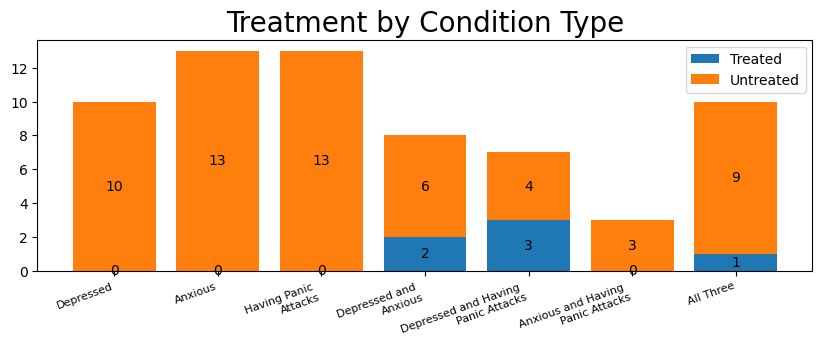

In [56]:
labels = ['Depressed', 'Anxious', 'Having Panic \nAttacks', 
                'Depressed and \nAnxious', 'Depressed and Having \nPanic Attacks', 
                'Anxious and Having \nPanic Attacks', 'All Three']

treated_counts = {
    "Treated" : [(only_depressed["Treated"] == 1).sum(), 
                 (only_anxious["Treated"] == 1).sum(), 
                 (only_panicking["Treated"] == 1).sum(),
                 (depressed_anxious["Treated"] == 1).sum(),
                 (depressed_panicking["Treated"] == 1).sum(),
                 (anxious_panicking["Treated"] == 1).sum(),
                 (all_three["Treated"] == 1).sum()],

    "Untreated" : [(only_depressed["Treated"] == 0).sum(), 
                 (only_anxious["Treated"] == 0).sum(), 
                 (only_panicking["Treated"] == 0).sum(),
                 (depressed_anxious["Treated"] == 0).sum(),
                 (depressed_panicking["Treated"] == 0).sum(),
                 (anxious_panicking["Treated"] == 0).sum(),
                 (all_three["Treated"] == 0).sum()]
}

fig, ax = plt.subplots(figsize = (10, 3))
bottom = np.zeros(7)

for treatment_type, treatment_count in treated_counts.items():
    p = ax.bar(labels,
                treatment_count,
                width = 0.8,
                label = treatment_type,
                bottom = bottom)
    bottom += treatment_count
    ax.bar_label(container = p, 
                 label_type = 'center',
                 fontsize = 10)

ax.set_title("Treatment by Condition Type", fontsize = 20)
plt.xticks(fontsize = 8, ha = 'right', rotation = 20)
ax.legend()
plt.show()
    

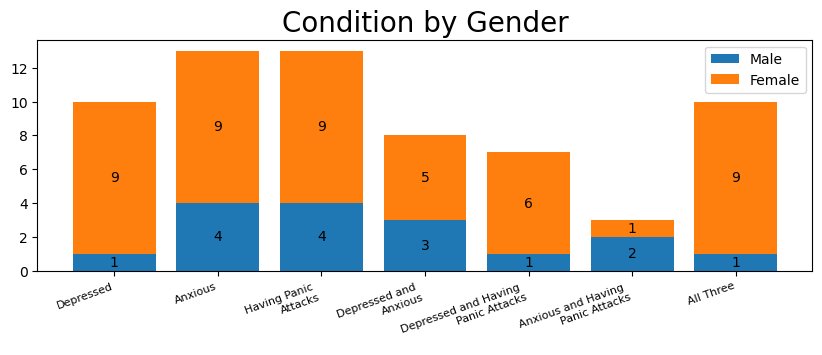

In [57]:
labels = ['Depressed', 'Anxious', 'Having Panic \nAttacks', 
                'Depressed and \nAnxious', 'Depressed and Having \nPanic Attacks', 
                'Anxious and Having \nPanic Attacks', 'All Three']

gender_counts = {
    "Male" : [(only_depressed["Gender"] == "Male").sum(), 
                 (only_anxious["Gender"] == "Male").sum(), 
                 (only_panicking["Gender"] == "Male").sum(),
                 (depressed_anxious["Gender"] == "Male").sum(),
                 (depressed_panicking["Gender"] == "Male").sum(),
                 (anxious_panicking["Gender"] == "Male").sum(),
                 (all_three["Gender"] == "Male").sum()],

    "Female" : [(only_depressed["Gender"] == "Female").sum(), 
                 (only_anxious["Gender"] == "Female").sum(), 
                 (only_panicking["Gender"] == "Female").sum(),
                 (depressed_anxious["Gender"] == "Female").sum(),
                 (depressed_panicking["Gender"] == "Female").sum(),
                 (anxious_panicking["Gender"] == "Female").sum(),
                 (all_three["Gender"] == "Female").sum()]
}

fig, ax = plt.subplots(figsize = (10, 3))
bottom = np.zeros(7)

for gender, gender_count in gender_counts.items():
    p = ax.bar(labels,
                gender_count,
                width = 0.8,
                label = gender,
                bottom = bottom)
    bottom += gender_count
    ax.bar_label(container = p, 
                 label_type = 'center',
                 fontsize = 10)

ax.set_title("Condition by Gender", fontsize = 20)
plt.xticks(fontsize = 8, ha = 'right', rotation = 20)
ax.legend()
plt.show()

In [58]:
print("Females: " + str((df["Gender"] == "Female").sum()) + "\nMales: " + str((df["Gender"] == "Male").sum()))

Females: 75
Males: 26


Because of the data imbalances between males and females, I am going to change the numbers to percentages to more accurately represent the data.

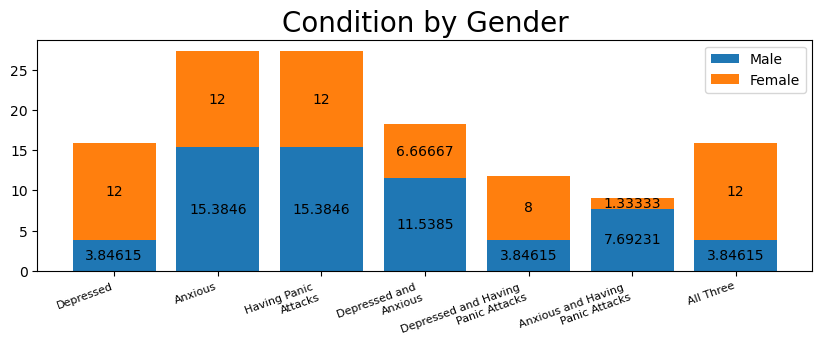

In [59]:
labels = ['Depressed', 'Anxious', 'Having Panic \nAttacks', 
                'Depressed and \nAnxious', 'Depressed and Having \nPanic Attacks', 
                'Anxious and Having \nPanic Attacks', 'All Three']

gender_counts = {
    "Male" : [(only_depressed["Gender"] == "Male").sum(), 
                 (only_anxious["Gender"] == "Male").sum(), 
                 (only_panicking["Gender"] == "Male").sum(),
                 (depressed_anxious["Gender"] == "Male").sum(),
                 (depressed_panicking["Gender"] == "Male").sum(),
                 (anxious_panicking["Gender"] == "Male").sum(),
                 (all_three["Gender"] == "Male").sum()],

    "Female" : [(only_depressed["Gender"] == "Female").sum(), 
                 (only_anxious["Gender"] == "Female").sum(), 
                 (only_panicking["Gender"] == "Female").sum(),
                 (depressed_anxious["Gender"] == "Female").sum(),
                 (depressed_panicking["Gender"] == "Female").sum(),
                 (anxious_panicking["Gender"] == "Female").sum(),
                 (all_three["Gender"] == "Female").sum()]
}

# The variables won't make as much sense now, but I'm changing individual counts to percentages.
# For example, instead of depressed males being 1 and depressed females being 9, 
# it will be 3.8 % of males are depressed and 12% of females are depressed.
# This makes it more fair to compare the two.

gender_counts["Male"] = gender_counts["Male"] / ((df["Gender"] == "Male").sum()) * 100
gender_counts["Female"] = gender_counts["Female"] / ((df["Gender"] == "Female").sum()) * 100

fig, ax = plt.subplots(figsize = (10, 3))
bottom = np.zeros(7)

for gender, gender_count in gender_counts.items():
    p = ax.bar(labels,
                gender_count,
                width = 0.8,
                label = gender,
                bottom = bottom)
    bottom += gender_count
    ax.bar_label(container = p, 
                 label_type = 'center',
                 fontsize = 10)

ax.set_title("Condition by Gender", fontsize = 20)
plt.xticks(fontsize = 8, ha = 'right', rotation = 20)
ax.legend()
plt.show()

You can see that this bar graph shows that a very similar amount of males and females are anxious or having panic attacks, instead of females having these conditions more than males.

## CGPA v. Year v. Condition

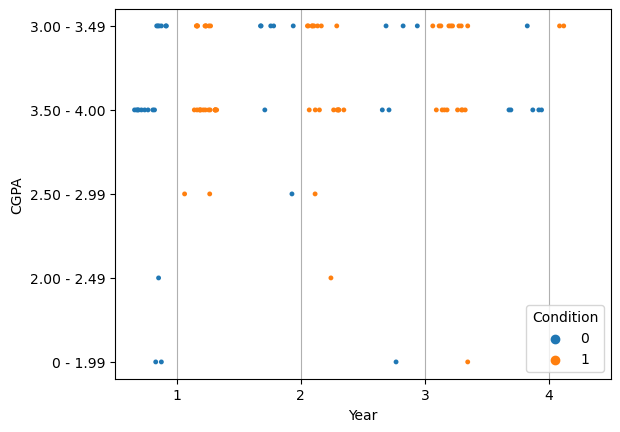

In [60]:
import warnings
warnings.filterwarnings('ignore')
grid = sns.stripplot(data = df, x = "Year", y = "CGPA", hue = "Condition", dodge = True, jitter = 0.3, size = 3.5)
plt.grid(axis = 'x')
plt.show()

Having CGPA as a categorial variable makes it difficult to perform tests and display data. This is because all the other variables (besides age) are categorical as well. 

<br>
<div class="alert alert-warning">
<b>WARNING</b> In general, the following method is a bad practice. Do NOT use this in formal analyses.
</div>

Alright I'm gonna do something totally uncool and pick a random number between the two bounds as each person's GPA. I just wanna do analysis and this data is preventing me from doing fun stuff. This is data manipulation and no longer allows for truthful insights but in order for the data to be more meaningful I'm going to do it. DO NOT DO THIS FOR OFFICIAL USE.

In [61]:
new_gpas = list()
cgpa = df.columns.get_loc("CGPA")

for row in range(len(df.index)):
    bounds = df.iloc[row, cgpa]
    bounds = bounds.split()
    del bounds[1]
    for index, b in enumerate(bounds):
        b = float(b)
        bounds[index] = b
    new_gpas.append(float(f'{random.uniform(*bounds):1.2f}'))

In [62]:
# THIS IS BAD PRACTICE!!! I WILL NOT SAY IT AGAIN, DON'T DO THIS IF YOU'RE TRYING TO USE THIS DATA IN AN ACCURATE WAY!
df["New GPA"] = new_gpas

This is the same graph as from above but with the modified data.

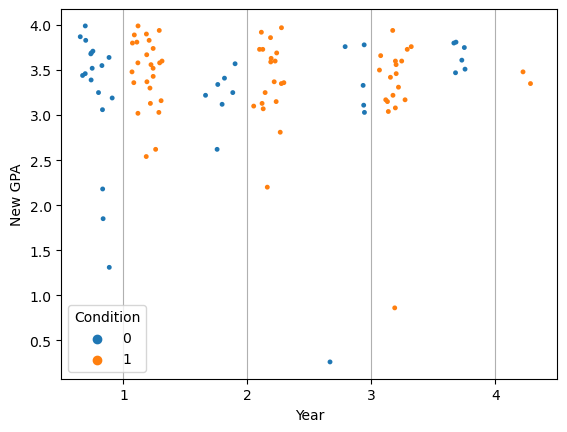

In [63]:
grid = sns.stripplot(data = df, x = "Year", y = "New GPA", hue = "Condition", dodge = True, jitter = 0.3, size = 3.5)
plt.grid(axis = 'x')
plt.show()

It looks so much better yeye

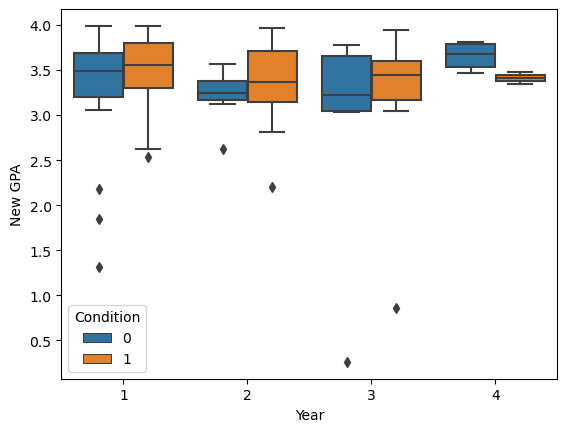

In [64]:
fig, ax = plt.subplots()
sns.boxplot(data = df, x = "Year", y = "New GPA", hue = "Condition")
plt.show()

## GPA v. Condition

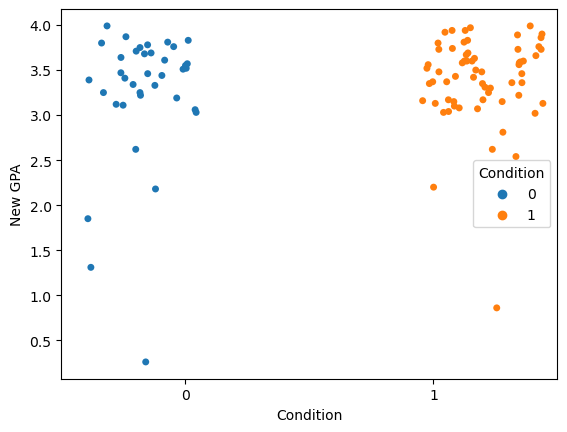

In [65]:
fig, ax = plt.subplots()
sns.stripplot(data = df, x = "Condition", y = "New GPA", hue = "Condition", dodge = True, jitter = 0.5, size = 5)
plt.show()

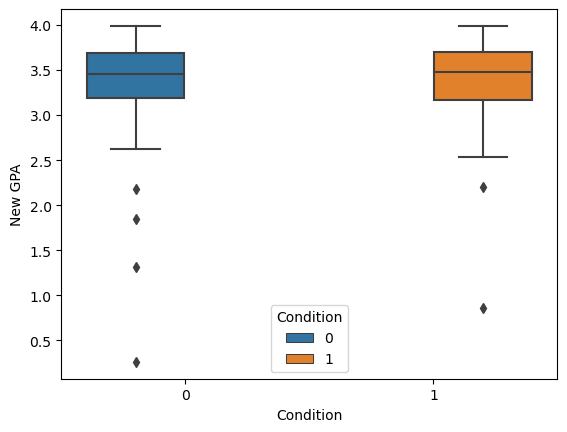

In [66]:
fig, ax = plt.subplots()
sns.boxplot(data = df, x = "Condition", y = "New GPA", hue = "Condition", )
plt.show()

Now I'll be testing to see if there's a difference in GPAs between people with/without a mental health condition (because it looks like there isn't). First, I have to see if I can make any assumptions about variance. 

# F-Test for variances
$H_0$: Variances are equal
<br> $H_A$: Variances are not equal

In [67]:
cond = df[df["Condition"] == 1]["New GPA"]
no_cond = df[df["Condition"] == 0]["New GPA"]

cond_var = np.var(cond)
no_cond_var = np.var(no_cond)
f_val = cond_var / no_cond_var

cond_df = len(cond) - 1             # DEGREES OF FREEDOM, NOT DATAFRAME!
no_cond_df = len(no_cond) - 1       # DEGREES OF FREEDOM, NOT DATAFRAME!

p_value = stats.f.cdf(f_val, cond_df, no_cond_df)

print("F-Statistic: {}\np-value: {}".format(f_val, p_value))

F-Statistic: 0.41834973337034304
p-value: 0.0012070541322213998


We reject the null that the two distributions have equal variances.

# Wilcoxon Rank-Sum Test 
Wilcoxon Rank-Sum is the nonparametric version of an independent t-test.
<br> $H_0$: Two groups are drawn from the same distribution
<br> $H_A$: Values in one sample are more likely to be larger or smaller than the values in the other sample

In [68]:
stats.ranksums(cond, no_cond, alternative = 'two-sided')

RanksumsResult(statistic=0.42643718004116693, pvalue=0.669789314117712)

We fail to reject the null that the two groups have the same distribution.
<br> Although Wilcoxon Rank-Sum isn't as strong as a t-test, it seems that there is no difference in the distribution of GPAs for people with a mental health condition versus people without.